## Importing libraries and authenticated access




In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from tqdm import tqdm
import calendar as ca

import time
import gc
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import LSTM
from keras import callbacks
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading the full dataset (5+ GB)

In [2]:
# https://www.kaggle.com/heyt0ny/read-data-for-low-memory-usage
class Data(object):
    def __init__(self, data_folder, test_the_script = False):
        self.DATA_FOLDER = data_folder
        self.test_the_script = test_the_script
        self.read_data()
        print('Train shape: ', self.train.shape)

    def read_data(self):

        self.nrows = None
        if self.test_the_script:
            self.nrows = 1000

        self.train = self.read_train_test_low_memory(train_flag = True)
        self.test = self.read_train_test_low_memory(train_flag = False)
        self.stores = self.read_stores_low_memory()
        self.items = self.read_items_low_memory()
        self.weather_oil_holiday = self.read_oil_weather_holiday_low_memory()
        self.transactions = self.read_transactions_low_memory()
        self.weather = self.read_weather_low_memory()
            
    def read_train_test_low_memory(self, train_flag = True):
        filename = 'train'
        if not train_flag: filename = 'test'

        types = {'id': 'int64',
                'item_nbr': 'int32',
                'store_nbr': 'int8',
                'unit_sales': 'float32'
            }
        # Skipping rows till 2016
        data = pd.read_csv(self.DATA_FOLDER + filename + '.csv', parse_dates = ['date'], dtype = types, 
                           converters={'unit_sales': lambda u: np.log1p(float(u)) if float(u) > 0 else 0},
                        nrows = self.nrows, infer_datetime_format = True, low_memory = True, skiprows=range(1, 66458909))
        
        # data['lg_unit_sales'] = data['unit_sales'].apply(lambda u: np.log1p(float(u)) if float(u) > 0 else 0)
        
        # Missing value imputation for onpromotion column
        data['onpromotion'].fillna(False, inplace = True)
        data['onpromotion'] = data['onpromotion'].map({False : 0, True : 1})
        data['onpromotion'] = data['onpromotion'].astype('int8')
        
        return data

    def read_stores_low_memory(self):
        types = {'cluster': 'int32',
                'store_nbr': 'int8',
                }
        data = pd.read_csv(self.DATA_FOLDER + 'stores.csv', dtype = types, low_memory = True)
        return data

    def read_items_low_memory(self):
        types = {'item_nbr': 'int32',
                'perishable': 'int8',
                'class' : 'int16'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'items.csv', dtype = types, low_memory = True)
        return data

    def read_oil_weather_holiday_low_memory(self):
        types = {'dcoilwtico_imputed': 'float32',
                 'AvgTemp': 'int8',
                 'store_nbr' : 'int8',
                 'is_holiday' : 'int8'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'holiday_weather_oil_combined.csv', parse_dates = ['date'], dtype = types, 
                                infer_datetime_format = True, low_memory = True)
        return data

    def read_weather_low_memory(self):
        types = {'AvgTemp': 'int8',
                 'MaxTemp': 'int8'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'weather.csv', parse_dates = ['Date'], dtype = types, 
                                infer_datetime_format = True, low_memory = True)
        data.rename(columns={'Date':'date', 'location':'city'}, inplace=True)
        return data
    
    def read_transactions_low_memory(self):
        types = {'transactions': 'int16',
                'store_nbr' : 'int8'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'transactions.csv', parse_dates = ['date'], dtype = types, 
                                infer_datetime_format = True, low_memory = True)
        return data

In [3]:
start_time = time.time()
data = Data(data_folder = 'drive/My Drive/Colab Notebooks/Wishmart/data/', test_the_script = False)
end_time = time.time()
print("Total time elapsed: {} mins.".format((end_time - start_time)/60))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: ParserWarning: Both a converter and dtype were specified for column unit_sales - only the converter will be used


Train shape:  (59038132, 6)
Total time elapsed: 3.6778085192044574 mins.


In [4]:
data.stores['city'] = data.stores.city.str.lower()
df_weather_store = pd.merge(data.stores[['store_nbr', 'city']], data.weather[['date', 'AvgTemp', 'city']], on='city')

# LGBM Starter

In [5]:
SELECTED_STORES = [i for i in range(1, 20)]
df_train = data.train.loc[(data.train.store_nbr.isin(SELECTED_STORES)) & (data.train.date >= datetime(2017, 1, 1))]

In [6]:
le = LabelEncoder()
data.items['family'] = le.fit_transform(data.items['family'].values)

data.stores['city'] = le.fit_transform(data.stores['city'].values)
data.stores['state'] = le.fit_transform(data.stores['state'].values)
data.stores['type'] = le.fit_transform(data.stores['type'].values)


data.items = data.items.reset_index()

In [7]:
df_train_ext = pd.merge(df_train, data.items[['item_nbr', 'perishable', 'family', 'class']], on='item_nbr')  # Train and items (perishable state)
df_train_ext = pd.merge(df_train_ext,
                    data.weather_oil_holiday[['date', 'store_nbr', 'is_holiday', 'AvgTemp', 'dcoilwtico_imputed']],
                    on=['date', 'store_nbr'], how='left')  # Merge weather, oil and holiday

del df_train_ext['id']
df_train_ext.rename(columns={'dcoilwtico_imputed': 'oil_price', 'AvgTemp': 'avg_temp', 'class': 'item_class'}, inplace=True)
df_train_ext.set_index(["store_nbr", "item_nbr", "date"], inplace=True)

In [8]:
df_2017 = df_train.set_index(["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

In [9]:
promo_2017 = df_train.set_index(["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(level=-1).fillna(0)
promo_2017.columns = promo_2017.columns.get_level_values(1)

In [10]:
holiday_2017 = df_train_ext[["is_holiday"]].unstack(level=-1).fillna(0)
holiday_2017.columns = holiday_2017.columns.get_level_values(1)

In [11]:
df_temp_2017 = df_train_ext[["avg_temp"]].unstack(level=-1).fillna(0)
df_temp_2017.columns = df_temp_2017.columns.get_level_values(1)

In [12]:
for col_date in tqdm(df_temp_2017.columns.get_level_values(0)):
  for row_store in df_temp_2017.index.levels[0]:
    avg_temp = df_weather_store.loc[(df_weather_store.store_nbr == row_store) & (df_weather_store.date == col_date)]['AvgTemp'].iloc[0]
    df_temp_2017.loc[df_temp_2017.index.get_level_values('store_nbr') == row_store, col_date] = avg_temp

100%|██████████| 226/226 [00:15<00:00, 14.85it/s]


In [13]:
data.items = data.items.set_index('item_nbr')
data.stores = data.stores.set_index('store_nbr')

In [14]:
df_items_2017 = data.items.reindex(df_2017.index.get_level_values(1))
df_stores_2017 = data.stores.reindex(df_2017.index.get_level_values(0))

In [15]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [16]:
# get_timespan(df_2017, date(2017, 5, 24)+timedelta(days=7 * 1), 1, 1).values.ravel().shape

In [17]:
def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({
        # "perishable": df_items_2017.perishable.values.ravel(),
        "day_1_2017": get_timespan(df_2017, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "mean_30_2017": get_timespan(df_2017, t2017, 30, 30).mean(axis=1).values,
        "mean_60_2017": get_timespan(df_2017, t2017, 60, 60).mean(axis=1).values,
        "mean_140_2017": get_timespan(df_2017, t2017, 140, 140).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values,
        "holiday_14_2017": get_timespan(holiday_2017, t2017, 14, 14).sum(axis=1).values,
        "holiday_60_2017": get_timespan(holiday_2017, t2017, 60, 60).sum(axis=1).values,
        "holiday_140_2017": get_timespan(holiday_2017, t2017, 140, 140).sum(axis=1).values,
        "day_1_temp": get_timespan(df_temp_2017, t2017, 1, 1).values.ravel(),
        "mean_2_temp": get_timespan(df_temp_2017, t2017, 2, 2).mean(axis=1).values,
        "mean_3_temp": get_timespan(df_temp_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_5_temp": get_timespan(df_temp_2017, t2017, 5, 5).mean(axis=1).values,
        "mean_7_temp": get_timespan(df_temp_2017, t2017, 7, 7).mean(axis=1).values
    })
    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 140-i, 20, freq='7D').mean(axis=1).values
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[t2017 + timedelta(days=i)].values.astype(np.uint8)
        # X["holiday_{}".format(i)] = holiday_2017[t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

In [18]:
print("Preparing dataset...")

t2017 = date(2017, 5, 24)
X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(t2017 + delta)

    X_tmp = pd.concat([X_tmp, df_items_2017.reset_index(), df_stores_2017.reset_index()], axis=1)
    
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l

X_val, y_val = prepare_dataset(date(2017, 7, 12))
X_val = pd.concat([X_val, df_items_2017.reset_index(), df_stores_2017.reset_index()], axis=1)

X_test, y_test = prepare_dataset(date(2017, 7, 31))
X_test = pd.concat([X_test, df_items_2017.reset_index(), df_stores_2017.reset_index()], axis=1)

Preparing dataset...


In [19]:
scaler = StandardScaler()
scaler.fit(pd.concat([X_train, X_val, X_test]))
X_train[:] = scaler.transform(X_train)
X_val[:] = scaler.transform(X_val)
X_test[:] = scaler.transform(X_test)

X_train = X_train.values
X_test = X_test.values
X_val = X_val.values
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [20]:
def build_model():

    model = Sequential()

    model.add(LSTM(32, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(.1))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))

    model.add(Dense(1))

    return model

In [21]:
N_EPOCHS = 1000

val_pred = []
test_pred = []

sample_weights = np.array(pd.concat([df_items_2017["perishable"]] * 6) * 0.25 + 1)
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)

    y = y_train[:, i]
    y_mean = y.mean()
    xv = X_val
    yv = y_val[:, i]

    model = build_model()
    opt = optimizers.Adam(lr=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
        ]

    model.fit(X_train, y - y_mean, batch_size = 65536, epochs = N_EPOCHS, verbose=2,
               sample_weight=sample_weights, validation_data=(xv,yv-y_mean), callbacks=callbacks )
    
    val_pred.append(model.predict(X_val)+y_mean)
    test_pred.append(model.predict(X_test)+y_mean)

Streaming output truncated to the last 5000 lines.
Epoch 7/1000
6/6 - 1s - loss: 0.8881 - mse: 0.8378 - val_loss: 0.8144 - val_mse: 0.8144
Epoch 8/1000
6/6 - 1s - loss: 0.8572 - mse: 0.8095 - val_loss: 0.8005 - val_mse: 0.8005
Epoch 9/1000
6/6 - 1s - loss: 0.8271 - mse: 0.7809 - val_loss: 0.7925 - val_mse: 0.7925
Epoch 10/1000
6/6 - 1s - loss: 0.8062 - mse: 0.7618 - val_loss: 0.7891 - val_mse: 0.7891
Epoch 11/1000
6/6 - 1s - loss: 0.7823 - mse: 0.7395 - val_loss: 0.7812 - val_mse: 0.7812
Epoch 12/1000
6/6 - 1s - loss: 0.7597 - mse: 0.7181 - val_loss: 0.7689 - val_mse: 0.7689
Epoch 13/1000
6/6 - 1s - loss: 0.7454 - mse: 0.7049 - val_loss: 0.7608 - val_mse: 0.7608
Epoch 14/1000
6/6 - 1s - loss: 0.7280 - mse: 0.6885 - val_loss: 0.7545 - val_mse: 0.7545
Epoch 15/1000
6/6 - 1s - loss: 0.7085 - mse: 0.6704 - val_loss: 0.7472 - val_mse: 0.7472
Epoch 16/1000
6/6 - 1s - loss: 0.6969 - mse: 0.6594 - val_loss: 0.7393 - val_mse: 0.7393
Epoch 17/1000
6/6 - 1s - loss: 0.6798 - mse: 0.6432 - val_loss

In [22]:
weight = df_items_2017["perishable"] * 0.25 + 1
err = (y_val - np.array(val_pred).transpose()[0])**2
err = err.sum(axis=1) * weight
err = np.sqrt(err.sum() / weight.sum() / 16)
print('nwrmsle = {}'.format(err))

nwrmsle = 0.6144262024118211


In [23]:
print("Test mse:", mean_squared_error(np.clip(np.expm1(y_val), 0, 1000), np.clip(np.expm1(np.array(val_pred).transpose()[0]), 0, 1000), sample_weight=(df_items_2017["perishable"].values * 0.25 + 1)))
print("Test mse:", mean_squared_error(np.clip(np.expm1(y_test), 0, 1000), np.clip(np.expm1(np.array(test_pred).transpose()[0]), 0, 1000), sample_weight=(df_items_2017["perishable"].values * 0.25 + 1)))

Test mse: 68.77240174791129
Test mse: 80.96957021722656


In [24]:
print("Combine with the test data split...")

df_preds_lg = pd.DataFrame(
    np.array(test_pred).transpose()[0], index=df_2017.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_predicted_unit_sales")
df_preds_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

df_test_lg = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_actual_unit_sales")
df_test_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


comb_df = pd.concat([df_preds_lg, df_test_lg], axis=1)
comb_df['predicted_unit_sales'] = np.clip(np.expm1(comb_df["log_predicted_unit_sales"]), 0, 1000)
comb_df['actual_unit_sales'] = np.clip(np.expm1(comb_df["log_actual_unit_sales"]), 0, 1000)
# comb_df['perishable'] = df_items_2017["perishable"]

Combine with the test data split...


In [25]:
groued_df = comb_df[['actual_unit_sales', 'predicted_unit_sales']].reset_index().groupby(['date', 'store_nbr']).sum().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To co

<Figure size 1440x360 with 0 Axes>

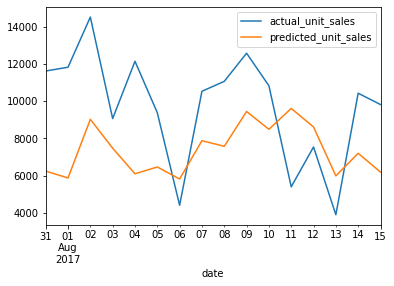

<Figure size 1440x360 with 0 Axes>

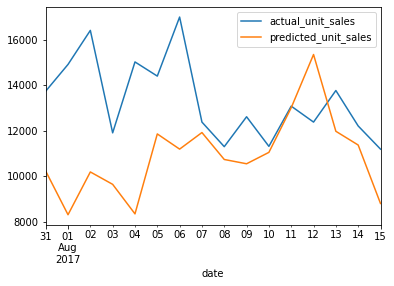

<Figure size 1440x360 with 0 Axes>

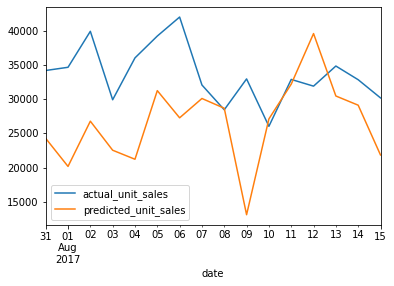

<Figure size 1440x360 with 0 Axes>

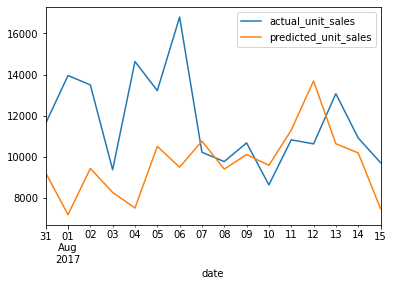

<Figure size 1440x360 with 0 Axes>

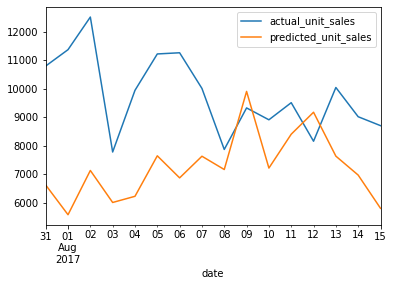

<Figure size 1440x360 with 0 Axes>

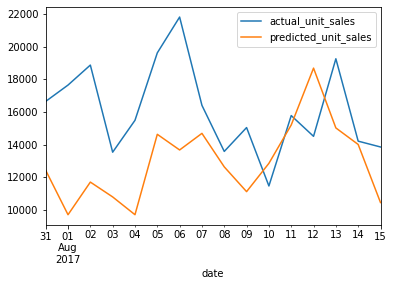

<Figure size 1440x360 with 0 Axes>

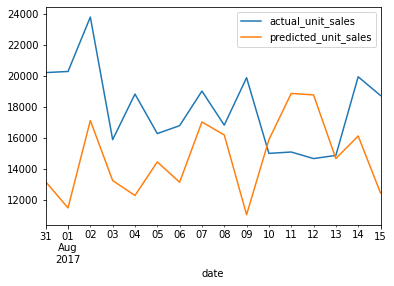

<Figure size 1440x360 with 0 Axes>

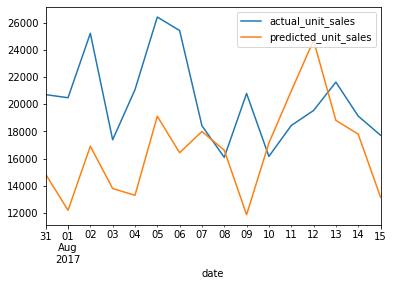

<Figure size 1440x360 with 0 Axes>

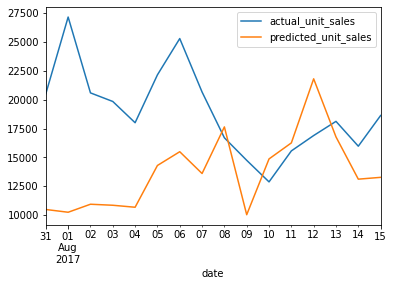

<Figure size 1440x360 with 0 Axes>

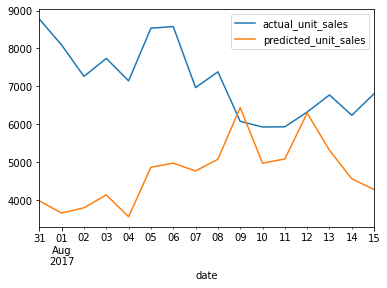

<Figure size 1440x360 with 0 Axes>

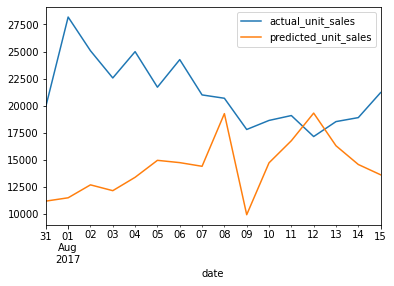

<Figure size 1440x360 with 0 Axes>

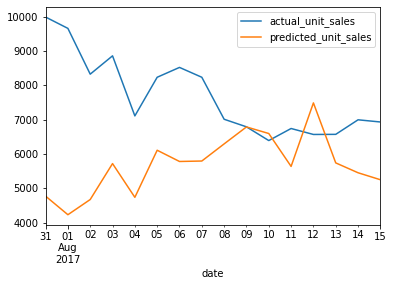

<Figure size 1440x360 with 0 Axes>

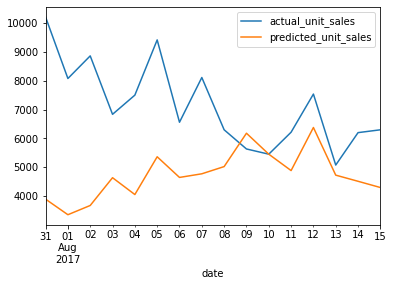

<Figure size 1440x360 with 0 Axes>

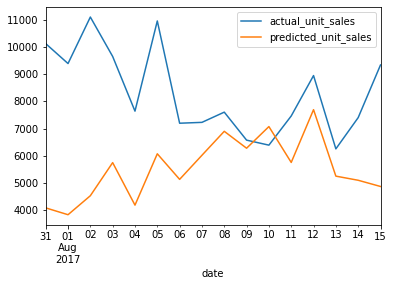

<Figure size 1440x360 with 0 Axes>

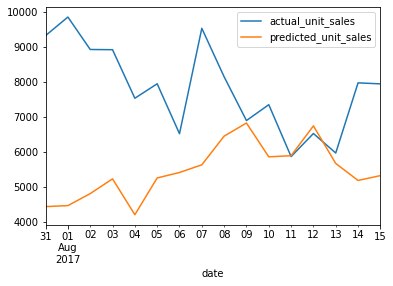

<Figure size 1440x360 with 0 Axes>

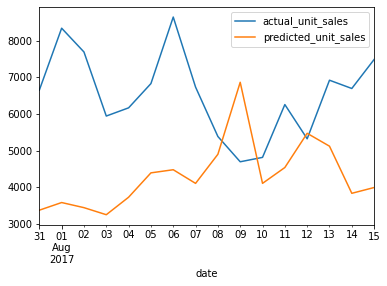

<Figure size 1440x360 with 0 Axes>

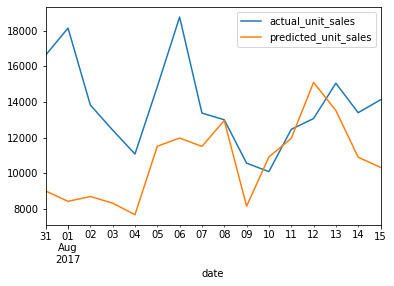

<Figure size 1440x360 with 0 Axes>

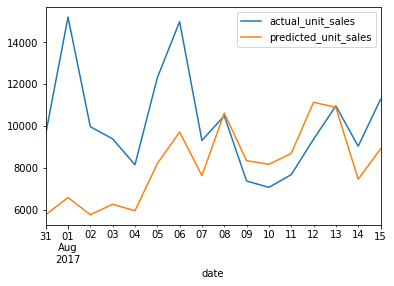

<Figure size 1440x360 with 0 Axes>

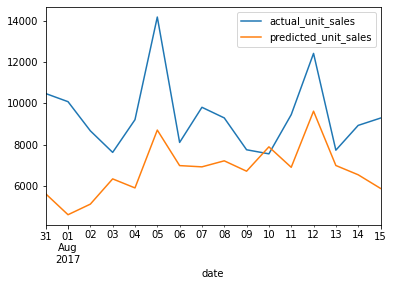

In [26]:
for i in range(1, 20):
  plt.figure(figsize=(20, 5))
  groued_df[groued_df.store_nbr == i].plot(x="date", y=["actual_unit_sales","predicted_unit_sales" ])

In [27]:
out_filename = 'drive/My Drive/Colab Notebooks/Wishmart/model_outputs/' + 'nn_log_scaled_out_full.csv'
merge_df = pd.merge(comb_df.reset_index(), df_items_2017.reset_index(), on='item_nbr')
merge_df.to_csv(out_filename, index=None)